<a href="https://colab.research.google.com/github/harshshaw/Flask-Apis-for-Hackathon/blob/main/Copy_of_Siamese_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siamese Neural Network

Siamese neural network is a class of neural network architectures that contain two or more identical sub networks. identical here means they have the same configuration with the same parameters and weights. Parameter updating is mirrored across both sub networks.It is used find the similarity of the inputs by comparing its feature vectors.

For more details check this blog : https://innovationincubator.com/siamaese-neural-network-with-paytorch-code-example/

## Steps to create classifier using Siamese Neural Network 


1.   **Data Preprocessing**
2.   **Define the Siamese Network**
3.   **Feature Vector Extraction**
4.   **Similarity Score Calculation**
5.   **Defininf Loss Function**
6.   **Optimizer**
7.   **Testing using One-Shot Learnig**
8.   **Making Predictions**



Let's  go step wise 

## Import and Install all the necessary packages

In [ ]:
pip install "wheel==0.34.2"

In [ ]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip3 install torch==1.8.1+cu102 torchvision==0.9.1+cu102 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
# Import all the necessary Library 
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 


In [ ]:
!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

### Additional Utility Functions 

In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
class Config():
    training_dir = "/content/drive/MyDrive/COVID"
    testing_dir = "/content/drive/MyDrive/COVID"
    train_batch_size = 32
    train_number_epochs = 20

## Load Dataset :

Datasets can be downloaded from this Link:  https://drive.google.com/file/d/1q03FLpaolm6Jq5vM0a_AEnjJoqjtxgP8/view?usp=sharing

**Copy the dataset directly to your drive and load it from there**

In [ ]:
!ls

drive				    sample_data
Matrix-Data.csv			    small_training_set.csv
new_training_Dataset2_balanced.csv  small_training_set.xlsx
new_training_Dataset2.csv	    test_training_dataset.csv
removed_training_value.csv


In [ ]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
training_dir="/content/drive/MyDrive/COVID"
training_csv="/content/new_training_Dataset2_balanced.csv"
testing_csv="/content/test_training_dataset.csv"
testing_dir="/content/drive/MyDrive/COVID"
original="/content/train_data.csv"

In [ ]:
''' training_df=pd.read_csv(training_csv,encoding="utf-8")

training_df=training_df.drop(columns='FORMAT')
training_df=training_df.drop(columns='SIZE')
first_half_image=training_df.iloc[0:1808,0:1].values
last_half_image=training_df.iloc[-1808:,0:1].values
new_first_image_column=pd.DataFrame(data=first_half_image,columns=['Image1'])
new_last_image_column=pd.DataFrame(data=last_half_image,columns=['Image2'])




training_df['label']=0
training_df['label2']=1
training_df.head() '''



' training_df=pd.read_csv(training_csv,encoding="utf-8")\n\ntraining_df=training_df.drop(columns=\'FORMAT\')\ntraining_df=training_df.drop(columns=\'SIZE\')\nfirst_half_image=training_df.iloc[0:1808,0:1].values\nlast_half_image=training_df.iloc[-1808:,0:1].values\nnew_first_image_column=pd.DataFrame(data=first_half_image,columns=[\'Image1\'])\nnew_last_image_column=pd.DataFrame(data=last_half_image,columns=[\'Image2\'])\n\n\n\n\ntraining_df[\'label\']=0\ntraining_df[\'label2\']=1\ntraining_df.head() '

In [ ]:
''' test_dataset=pd.read_csv("/content/Normal_Converted.metadata.csv")

test_dataset=test_dataset.drop(columns="FORMAT")
test_dataset=test_dataset.drop(columns="SIZE")
test_dataset.head() '''


' test_dataset=pd.read_csv("/content/Normal_Converted.metadata.csv")\n\ntest_dataset=test_dataset.drop(columns="FORMAT")\ntest_dataset=test_dataset.drop(columns="SIZE")\ntest_dataset.head() '

### Preprocessing and Loading Dataset

We preprocessed all the images and loaded them as .npy files which is easy to transfer . You can follow your own preprocessing steps .


In [ ]:
class SiameseNetworkDataset():
   
    def __init__(self,training_csv=None,training_dir=None,transform=None,pairwise=None):
        # used to prepare the labels and images path
        self.pairwise=pairwise
        if(self.pairwise==False):
          self.training_df=pd.read_csv(training_csv,encoding="utf-8")
          self.training_df.columns =["image1","image2","label"]
          print("CSV==",self.training_df)
          self.training_dir = training_dir    
          self.transform = transform
          
        if(pairwise==True):
          self.training_df=pd.read_csv(training_csv,encoding="utf-8")
          self.training_df.columns =["Target","Reference","assigned","Original"]
          
          self.training_dir = training_dir    
          print("Directory===",self.training_dir)
          print("CSV==",self.training_df)
          self.transform = transform

    def __getitem__(self,index):

        # getting the image path
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        
     
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])
        
     
        

        
        
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))
    
    def __len__(self):
        return len(self.training_df)

In [ ]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseNetworkDataset(training_csv,training_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ]
                                                                    ),
                                        pairwise=False
                                       )

CSV==               image1           image2  label
0     COVID-1535.png   COVID-3343.png      0
1     COVID-1536.png   COVID-3344.png      0
2     COVID-1537.png   COVID-3345.png      0
3     COVID-1789.png   COVID-3597.png      0
4     COVID-1790.png   COVID-3598.png      0
...              ...              ...    ...
2443  COVID-3029.png  Normal-1279.png      1
2444  COVID-3030.png  Normal-1280.png      1
2445  COVID-3031.png  Normal-1281.png      1
2446  COVID-3032.png  Normal-1282.png      1
2447  COVID-3033.png  Normal-1283.png      1

[2448 rows x 3 columns]


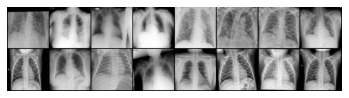

[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]]


In [ ]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Siamese Network Definition

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(46464, 8192),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(8192, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),

            nn.Linear(512, 128),
            
            )
        
  
  
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2


### Loss Function

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) *( torch.pow(euclidean_distance, 2)) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

### Train the Model

In [ ]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Check whether you have GPU is loaded or not
if torch.cuda.is_available():
    print('Yes')

Yes


In [ ]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99, eps=1e-8, weight_decay=0.005, momentum=0.5)

In [ ]:
def train():
    counter = []
    loss_history = [] 
    iteration_number= 0
    
    for epoch in range(0,100):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %50 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    return net

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
model = train()
torch.save(model.state_dict(), "/content/model.pt")
print("Model Saved Successfully")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch number 0
 Current loss 1.4254844188690186

Epoch number 0
 Current loss 0.9954209923744202

Epoch number 1
 Current loss 1.0099773406982422

Epoch number 1
 Current loss 1.0186259746551514

Epoch number 2
 Current loss 1.0153181552886963

Epoch number 2
 Current loss 1.0379300117492676

Epoch number 3
 Current loss 1.0180317163467407

Epoch number 3
 Current loss 1.0208654403686523

Epoch number 4
 Current loss 1.020500659942627

Epoch number 4
 Current loss 0.8953791260719299

Epoch number 5
 Current loss 1.009263277053833

Epoch number 5
 Current loss 1.0604498386383057

Epoch number 6
 Current loss 1.3165881633758545

Epoch number 6
 Current loss 1.0342726707458496

Epoch number 7
 Current loss 1.0443341732025146

Epoch number 7
 Current loss 1.0006532669067383

Epoch number 8
 Current loss 0.9440956115722656

Epoch number 8
 Current loss 1.0868064165115356

Epoch number 9
 Current loss 1.039902925491333

Epoch number 9
 Current loss 1.0377246141433716

Epoch number 10
 Curren

In [ ]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("/content/model.pt"))

In [ ]:
# Load the test dataset
''' test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=testing_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ]),
                                     pairwise=False
                                       )

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=False) '''

### Accuracy Check

In [ ]:
''' import math
test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)
accuracy=0
counter=0
correct=0
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
 
  # onehsot applies in the output of 128 dense vectors which is then converted to 2 dense vectors
  output1,output2 = model(x0.to(device),x1.to(device))
  res=torch.abs(output1-output2)
  res=torch.abs(output1.cuda() - output2.cuda())
 
  label=label[0].tolist()
  label=int(label[0])
  result=torch.max(res,1)[0].item()
 
  if(result<0.001):
    result=0
  if(result>=0.001):
    result=1
 
  if label == result:
    correct=correct+1
  counter=counter+1
#   if counter ==20:
#      break
    
accuracy=(correct/len(test_dataloader))*100
print("Accuracy:{}%".format(accuracy)) '''

In [ ]:
row_value=40
matrix=np.zeros((row_value,10))
print(matrix)
   
  


In [ ]:
matrix_dataset = SiameseNetworkDataset(training_csv="Matrix-Data.csv",training_dir=training_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ]),
                                     pairwise=True
                                       )

matrix_loader = DataLoader(matrix_dataset,num_workers=6,batch_size=1)

In [ ]:
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
column=0
row=0
for i, data in enumerate(matrix_loader,1): 
  x0, x1 , label = data
  output1,output2 = model(x0.to(device),x1.to(device))
 
  eucledian_distance = F.pairwise_distance(output1, output2)
  if row==row_value:
    break
  matrix[row][column]=(eucledian_distance)
  column=column+1
  if column==10:
    row=row+1
    column=0
  

  ''' concatenated = torch.cat((x0,x1),0)
  if label==list_0:
    label="Orginial"
  else:
    label="Forged"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.3f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1 '''
        
    

  

In [ ]:

print(matrix)
column_index=0
highest_value=[]
for row in range(0,row_value):
  max=100
  for column in range(0,10):
    if (max>=matrix[row][column]):
      max=matrix[row][column]
      column_index=column
  highest_value.append(column_index)
print(highest_value)



In [ ]:
similarity_data=pd.read_csv("/content/Matrix-Data.csv",encoding='utf-8')
similarity_data.head()
counter=0
precision=0
for index in highest_value:

  index+=counter*10
  assigned_label=similarity_data.iat[index,2]
  original_label=similarity_data.iat[index,3]
  reference=similarity_data.iat[index,1]
  target=similarity_data.iat[index,0]
  counter=counter+1
  print("Target==",target,"Reference==",reference,"Index==",index)
  

  if assigned_label==original_label:
    precision+=1
accuracy=(precision/40)*100


print(accuracy)
  

## Final Touch 

Thats it guys ! I am limited by time , computational power and knowledge .to get standard accuracy . But anyway this is the working code of Siamese Neural Network and you can try it for your own applications and dataset.

Paper Reference: https://arxiv.org/pdf/1707.02131.pdf

Thanks to Gupta Blog : https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e